In [3]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 1000

In [6]:
data = pd.read_csv('sales-data.csv',parse_dates=['barr_date'])

data = data[(data.region_name=="China") & (data.business_area_name=="F00 - GCCT")]
display(data.head())

data.rename(columns={"barr_date":"date","revenue": "sales"}, inplace=True)
data = data[['date','sales']]
data.set_index('date', inplace=True)
display(data)

,business_area_name,region_name,barr_date,revenue
78,F00 - GCCT,China,2021-12-01,0.00
110,F00 - GCCT,China,2021-11-01,0.00
296,F00 - GCCT,China,2021-03-01,24220.24
413,F00 - GCCT,China,2020-10-01,18626.77
900,F00 - GCCT,China,2019-02-01,-42.74


,sales
date,
2021-12-01,0.00
2021-11-01,0.00
2021-03-01,24220.24
2020-10-01,18626.77
2019-02-01,-42.74
2018-12-01,27273.90
2018-11-01,-857.38
2018-10-01,90343.25
2018-07-01,11355.99


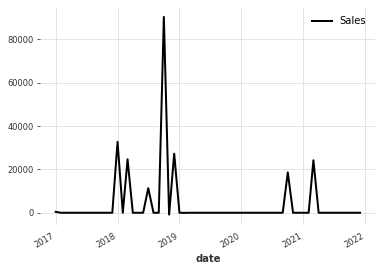

In [10]:
series_sales = TimeSeries.from_dataframe(data,fill_missing_dates=True, freq=None,fillna_value=0)

plt.ticklabel_format(style='plain')
series_sales.plot(label="Sales")
plt.legend()

In [11]:
data2 = pd.read_csv('commodity_index.csv',parse_dates=['ts_month'])

data2 = data2[(data2.ts_month>='2017-01-01')]
display(data2.head())

data2.rename(columns={"ts_month":"date","commodity_index": "values"}, inplace=True)
data3 = data2[['date','gold_index']]
data4 = data2[['date','silver_index']]
data5 = data2[['date','palladium_index']]
data6 = data2[['date','platinum_index']]

data2 = data2[['date','values']]
data2.set_index('date', inplace=True)
#display(data2.head())

data3.set_index('date', inplace=True)
#display(data3.head())

data4.set_index('date', inplace=True)
#display(data4.head())

data5.set_index('date', inplace=True)
#display(data5.head())

data6.set_index('date', inplace=True)
#display(data6.head())

,ts_month,copper_index,ironore_index,lead_index,molybdenum_index,nickel_index,uranium_index,zinc_index,gold_index,platinum_index,palladium_index,silver_index,commodity_index
95,2017-01-01,0.60,0.44,0.86,0.39,0.39,0.34,1.15,0.88,0.54,0.94,0.59,0.81
96,2017-02-01,0.62,0.49,0.89,0.41,0.42,0.37,1.20,0.91,0.56,0.97,0.63,0.85
97,2017-03-01,0.61,0.48,0.88,0.43,0.40,0.37,1.17,0.90,0.54,0.98,0.62,0.83
98,2017-04-01,0.60,0.39,0.86,0.50,0.38,0.34,1.11,0.93,0.54,1.01,0.63,0.81
99,2017-05-01,0.59,0.34,0.83,0.50,0.36,0.32,1.09,0.92,0.52,1.00,0.59,0.80


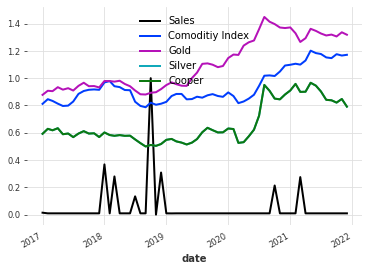

In [12]:
series_commodities = TimeSeries.from_dataframe(data2)
series_gold = TimeSeries.from_dataframe(data3)
series_silver = TimeSeries.from_dataframe(data4)
series_cooper = TimeSeries.from_dataframe(data5)
#series_platinum = TimeSeries.from_dataframe(data6)

scaler_sales, scaler_commodities, scaler_gold, scaler_silver, scaler_cooper, scaler_platinum = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
series_sales_scaled = scaler_sales.fit_transform(series_sales)
series_commodities_scaled = scaler_commodities.fit_transform(series_commodities)
series_gold_scaled = scaler_gold.fit_transform(series_gold)
series_silver_scaled = scaler_silver.fit_transform(series_silver)
series_cooper_scaled = scaler_cooper.fit_transform(series_cooper)
#series_platinum_scaled = scaler_platinum.fit_transform(series_platinum)

plt.ticklabel_format(style='plain')
series_sales_scaled.plot(label="Sales")
series_commodities.plot(label="Comoditiy Index")
series_gold.plot(label="Gold")
series_silver.plot(label="Silver")
series_silver.plot(label="Cooper")
#series_platinum.plot(label="Platinum")
plt.legend()

In [14]:
train_sales, val_sales = series_sales_scaled[:-12], series_sales_scaled[-12:]
train_commodities, val_commodities = series_commodities_scaled[:-12], series_commodities_scaled[-12:]
train_gold, val_gold = series_gold_scaled[:-12], series_gold_scaled[-12:]
train_silver, val_silver = series_silver_scaled[:-12], series_silver_scaled[-12:]
train_cooper, val_cooper = series_cooper_scaled[:-12], series_cooper_scaled[-12:]
#train_platinum, val_platinum = series_platinum_scaled[:-12], series_platinum_scaled[-12:]
#train_miningGDP, val_miningGDP = series_miningGDP_scaled[:-12], series_miningGDP_scaled[-12:]

In [33]:
model_sales = NBEATSModel(input_chunk_length=16, output_chunk_length=12, n_epochs=50, random_state=0)
model_sales.fit([train_sales],verbose=True)

[2022-05-10 10:12:42,479] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21 samples.
[2022-05-10 10:12:42,479] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 21 samples.
2022-05-10 10:12:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 21 samples.
[2022-05-10 10:12:42,545] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-10 10:12:42,545] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-10 10:12:42 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-05-10 10:12:42,548] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning T

Training: 0it [00:00, ?it/s]

In [34]:
pred = model_sales.predict(n=24, series=train_sales)

Predicting: 1it [00:00, ?it/s]

MAPE = 698.66%


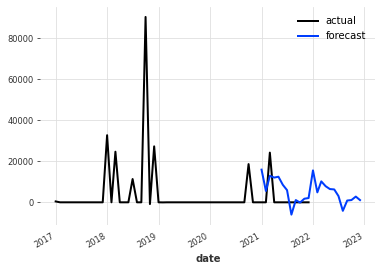

In [35]:
original = scaler_sales.inverse_transform(series_sales_scaled)
predicted = scaler_sales.inverse_transform(pred)

plt.ticklabel_format(style='plain')
original.plot(label="actual")
predicted.plot(label="forecast")
plt.legend()

print("MAPE = {:.2f}%".format(mape(series_sales_scaled, pred)))

In [36]:
xxx = predicted['sales'].pd_dataframe()
xxx

component,sales
date,
2021-01-01,15924.41
2021-02-01,5527.45
2021-03-01,12917.50
2021-04-01,12055.79
2021-05-01,12469.80
2021-06-01,8524.50
2021-07-01,5931.15
2021-08-01,-5999.60
2021-09-01,1096.57
